# Combinatorial library properties

## Aim of this notebook

In this notebook we want to analyze properties of the combinatorial library:

1. Recombined ligands compliant with Lipinski's rule of five (criteria) in comparison to KLIFS and PKIDB ligands
2. Recombined ligand sizes (number of heavy atoms)

**Note** that the combinatorial library is stored as `json` file (6.7M molecules). The data needed for this notebook was extracted previously in notebook `4_1_combinatorial_library_data.ipynb` for easy and fast access here. In order to run this notebook, download data from https://osf.io/cy7tr/ and save files to `../data/combinatorial_library/`. 

## Table of contents

1. Lipinski's rule of five
2. Recombined ligand size
3. Number of subpockets

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from pathlib import Path

import ijson
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem

from utils import get_original_ligands, get_ro5_from_mol, read_fragment_library

## 1. Lipinski's rule of five

### Recombined ligands

Load recombined ligands' properties (number of ligands that fulfill Lipinski's rule of five (and its individual criteria) and number of ligands in total).

In [3]:
properties = pd.read_csv(
    '../data/combinatorial_library/ro5.csv',
    header=None,
    index_col=0,
    squeeze=True
)
properties

0
mw           3210322
logp         3946081
hbd          6701625
hba          6002105
lipinski     4260776
n_ligands    6720637
Name: 1, dtype: int64

Get ratio of ligands that fulfill the Lipinski's rule of five (and its individual criteria)

In [4]:
ro5_comb = round(
    properties[['mw', 'logp', 'hbd', 'hba', 'lipinski']] / properties['n_ligands'] * 100, 
    0
)
ro5_comb = ro5_comb.astype('int')
ro5_comb

0
mw           48
logp         59
hbd         100
hba          89
lipinski     63
Name: 1, dtype: int64

### PKIDB ligands

Compare the recombined ligands to the PKIDB ligands, i.e. approved and investigorial kinase inhibitors.

- Database: https://www.icoa.fr/pkidb/
- Publication: [Carles et al. (2018)](https://www.mdpi.com/1420-3049/23/4/908)

Since there is no option to download the table from the PKIDB currently (July 2020), we parsed the data into a CSV file using web scraping (https://github.com/dominiquesydow/pkidb_klifs).

In [5]:
data_pkidb = pd.read_csv('https://raw.githubusercontent.com/dominiquesydow/pkidb_klifs/master/results/pkidb_20200218.csv', index_col=0)
print(f'Number of ligands in PKIDB data: {data_pkidb.shape[0]}')

Number of ligands in PKIDB data: 218


In [6]:
data_pkidb.head(2)

,INN_Name,BrandName,Phase,Applicants,LigID,pdbID,Type,RoF,MW,LogP,...,Targets,Kinase_families,First_Approval,SC_Patent,Chirality,Synonyms,FDA_approved,Melting_points_C,Canonical_Smiles,InChIKey
0,Leniolisib,NaN,0.0,Novartis,9NQ,['5o83'],NaN,0,450.2,2.9,...,NaN,NaN,NaN,NaN,Single Stereoisomer,"['CDZ173-NX', 'Leniolisib']",NaN,NaN,CCC(=O)N1CC[C@@H](C1)Nc2c3c(ncn2)CCN(C3)c4cc(c...,MWKYMZXCGYXLPL-ZDUSSCGKSA-N
1,Nemiralisib,NaN,0.0,GlaxosmithKline,VVX,['5ae8'],NaN,0,440.2,4.9,...,NaN,NaN,NaN,NaN,Single Stereoisomer,"['GSK2269557A', 'GSK-2269557', 'Nemiralisib']",NaN,NaN,CC(C)N1CCN(CC1)Cc2cnc(o2)c3cc(cc4c3cn[nH]4)c5c...,MCIDWGZGWVSZMK-UHFFFAOYSA-N


In [7]:
ro5_pkidb = round(
    data_pkidb.Canonical_Smiles.apply(
        Chem.MolFromSmiles
    ).apply(get_ro5_from_mol).sum() / data_pkidb.shape[0] * 100, 
    0
)
ro5_pkidb = ro5_pkidb.astype('int')
ro5_pkidb

mw           70
logp         74
hbd         100
hba          99
lipinski     85
dtype: int64

### Original ligands

Compare the recombined ligands to the KLIFS ligands that were used to generate the fragment library (original ligands).

- Database: https://klifs.vu-compmedchem.nl/
- Publications: [van Linden et al. (2014)](https://pubs.acs.org/doi/abs/10.1021/jm400378w) and [Kooistra et al. (2016)](https://academic.oup.com/nar/article/44/D1/D365/2502606)

Note that we only use a subset of KLIFS ligands here, i.e. the ligands used for the fragmentation.

In [8]:
data_klifs = pd.read_json('../data/fragment_library/original_ligands.json')
print(f'Number of original KLIFS ligands: {data_klifs.shape[0]}')

Number of original KLIFS ligands: 2553


In [9]:
data_klifs.head(2)

,complex_pdb,ligand_pdb,subpocket,kinase,family,group,alt,chain,ac_helix,smiles,inchi
0,1a9u,SB2,"[AP, GA, B2]",p38a,MAPK,CMGC,,A,out-like,C[S@](=O)c1ccc(-c2nc(-c3ccc(F)cc3)c(-c3ccncc3)...,InChI=1S/C21H16FN3OS/c1-27(26)18-8-4-16(5-9-18...
1,1agw,SU2,"[AP, SE]",FGFR1,FGFR,TK,B,B,out-like,O=CN1CCN(c2ccc(C[C@@H]3C(=O)Nc4ccccc43)cc2)CC1,InChI=1S/C20H21N3O2/c24-14-22-9-11-23(12-10-22...


In [10]:
ro5_klifs = round(
    data_klifs.smiles.apply(
        Chem.MolFromSmiles
    ).apply(get_ro5_from_mol).sum() / data_klifs.shape[0] * 100, 
    0
)
ro5_klifs = ro5_klifs.astype('int')
ro5_klifs

mw          88
logp        94
hbd         99
hba         99
lipinski    97
dtype: int64

### Plot properties

In [11]:
# Collect data in one DataFrame
bar_data = pd.DataFrame(
    {
        f'Recombined ligands (#{properties["n_ligands"]})': ro5_comb, 
        f'Original KLIFS ligands (#{data_klifs.shape[0]})': ro5_klifs, 
        f'PKIDB ligands (#{data_pkidb.shape[0]})': ro5_pkidb
    }
)
bar_data = bar_data.astype('int32')
bar_data

,Recombined ligands (#6720637),Original KLIFS ligands (#2553),PKIDB ligands (#218)
0,,,
mw,48,88,70
logp,59,94,74
hbd,100,99,100
hba,89,99,99
lipinski,63,97,85


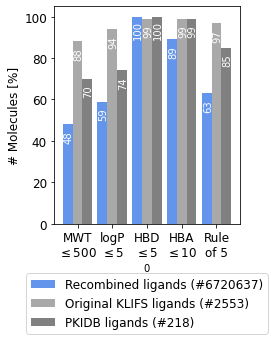

In [12]:
# Plot data
ax = bar_data.plot(
    kind='bar',
    width=0.85,
    rot=0,
    figsize=(3.33, 4),
    color=['cornflowerblue', 'darkgrey', 'grey']
)

# Edit labels for y axis and x/y ticks
plt.ylabel('# Molecules [%]', fontsize=12)
plt.xticks(range(5), ['MWT\n'+r'$\leq 500$', 'logP\n'+r'$\leq 5$', 'HBD\n'+r'$\leq 5$', 'HBA\n'+r'$\leq 10$', 'Rule\nof 5'], fontsize=12)
plt.yticks(fontsize=12)
#plt.legend(fontsize=12, loc='upper left')
legend = plt.legend(loc='upper center', 
           bbox_to_anchor=(0.5,-.2),
           fontsize=12
          )

# Add percentages to bars
bars = ax.patches
bar_labels = bar_data.transpose().values.flatten()
for bar, label in zip(bars, bar_labels):
    
    plt.text(
        bar.get_x() + bar.get_width() / 1.6, 
        bar.get_height() - 6,
        label, 
        ha='center', 
        va='center', 
        fontsize=10,
        color='white',
        rotation=90
    )

In [13]:
ax.get_figure().savefig(
    'figures/combinatorial_library_ro5.pdf',
    bbox_extra_artists=(legend,),
    bbox_inches='tight'
)

## 2. Recombined ligand size

Take a look at the average number of heavy atoms in the combinatorial library.

In [14]:
n_atoms = pd.read_csv('../data/combinatorial_library/n_atoms.csv', header=None).squeeze()
len(n_atoms)

6720637

Text(0.5, 0, 'Number of heavy atoms')

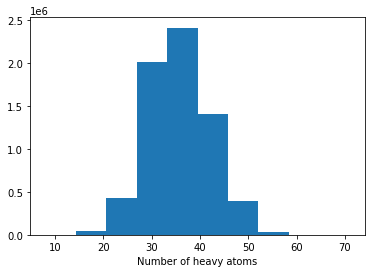

In [15]:
plt.hist(n_atoms)
plt.xlabel('Number of heavy atoms')

In [16]:
n_atoms.describe(percentiles=[.01, .1, .25, .5, .75, .99])

count    6.720637e+06
mean     3.572235e+01
std      6.344317e+00
min      8.000000e+00
1%       2.200000e+01
10%      2.800000e+01
25%      3.100000e+01
50%      3.600000e+01
75%      4.000000e+01
99%      5.100000e+01
max      7.100000e+01
Name: 0, dtype: float64

98% of recombined ligands have between 22 and 51 heavy atoms (on average 36).

In [17]:
# Delete object (since very large with ~6M entries)
del n_atoms

## 3. Number of subpockets

In [18]:
subpockets = pd.read_csv('../data/combinatorial_library/subpockets.csv', index_col=0)
subpockets['n_subpockets'] = [len(i.split('-')) for i in subpockets.index]
subpockets

,count,n_subpockets
AP-B1-GA-SE,255096,4
AP-FP-GA-SE,5016284,4
AP-B2-GA-SE,359534,4
AP-B2-FP-GA,178027,4
AP-B1-FP-GA,209843,4
AP-B1-B2-GA,3498,4
AP-GA-SE,102733,3
AP-FP-SE,512671,3
AP-FP-GA,71885,3
AP-B2-GA,1812,3


In [19]:
n_subpockets = subpockets.groupby('n_subpockets').sum()
n_subpockets['ratio'] = round(n_subpockets['count'] / n_subpockets['count'].sum() * 100, 2)
n_subpockets

,count,ratio
n_subpockets,,
2,7975,0.12
3,690380,10.27
4,6022282,89.61


The majority of recombined ligands are composed of 4 fragments (occupying 4 subpockets), whereas the majority of original igands is smaller and occupies 2-3 subpockets (check out `notebooks/2_2_fragment_analysis_statistics.ipynb`). This is to be expected since all fragment combinations were allowed up to 4 fragments during the recombination process.